# Medical Imaging Preprocessing

> A walk-through tutorial how to process, manipulate, and save medical images. 
- toc: true
- use_math: true
- comments: true
- use_plotly: true

## Background

In this tutorial, we will review how to process, handle, and save DICOM data. A great resource to access medical imaging data is through the [Cancer Imaging Archive](https://www.cancerimagingarchive.net/collections/). They maintain an archive of medical images across various datasets that are accessible for public download. We will be using scans from the [LIDC-IDRI](https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX) dataset which contains diagnostic and lung cancer screening thoracic computed tomography (CT) scans with annotated lesions in XML format. To handle the annotated lessions, researchers have developed the [pylidc](https://pylidc.github.io/tuts/scan.html) for processing the XML files. 

In [1]:
#hide
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pydicom
import scipy.ndimage
import sys

from pathlib import Path

In [2]:
PATH = 'data/LIDC-IDRI'

def get_dicom_directories(input_dir: str) -> list:
    ''''Get directory up until parent of all subdirectories that contain DICOM
        files
    Args:
        input_dir (str): path to the input directory of DICOM files
        
    Returns:
        list: subdirectories in input_dir that contain DICOM files
    
    Raises:
        ValueError: checks if any DICOM files exist in input_dir
    '''
    dicom_directories = list(set([path.parent for path in Path(input_dir).rglob('*.dcm')]))

    if not dicom_directories:
        raise ValueError(f'{input_dir} contains no DICOM files')

    return dicom_directories

In [3]:
get_dicom_directories(PATH)[:3]

[PosixPath('data/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-NA-NA-98329/3000522.000000-NA-04919'),
 PosixPath('data/LIDC-IDRI/LIDC-IDRI-0005/01-01-2000-NA-NA-42125/3000548.000000-NA-86225'),
 PosixPath('data/LIDC-IDRI/LIDC-IDRI-0008/01-01-2000-NA-NA-30141/3000549.000000-NA-21954')]

## DICOM files

Without going into intensive detail, we should know that CT scans produce an image by producing cross-sectional images from an X-Ray and then reconstruct the slices to form a volumetric image. Each slice is saved to a DICOM file which stores the pixel array and metadata for that particular slice. We can sort the list of DICOM files by the image position of the patient to construct a volumetric image and then sort the slices in ascending order. If you're interested in learning about the physics of medical imaging and how images are produced, I recommend [Fundamentals of Medical Imaging](https://doi.org/10.1017/CBO9780511596803).

After sorting DICOM files by ```SliceLocation```, we can load the DICOM files in the correct order. Looking at the first DICOM file, we can see all the metadata information that is stored. We'll need this to process and store our data in a more appropriate format.

DICOM or Digital Imaging and Communications in Medicine is a standardized file format for medical imaging information and related data. Typically, you will see the raw medical images stored in this format and later processed to an easier to handle format such as [NIfTI](https://radiopaedia.org/articles/nifti-file-format#:~:text=NIfTI%20is%20a%20type%20of,neuroscience%20and%20even%20neuroradiology%20research.) or [Nrrd](http://teem.sourceforge.net/nrrd/format.html). To process our DICOM files, we are using the ```pydicom``` library and have constructed and read a list of ```pydicom.dataset.FileDataset``` objects with our ```scan``` list. This object allows to access any relevant data elements stored in the DICOM file, useful data elements include ```Modality, RescaleIntercept, RescaleSlope, PixelSpacing, SliceThickness,``` and ```ImagePositionPatient```. We'll need these data elements to standardize our scans to the same pixel spacing and covert our pixel values to the Hounsfield scale. It could also be helpful to use these data elements and construct an array of metadata elements to use for training. This is particularly useful in case you want to identify any subtleties between CT manufacturers. The [DICOM library](https://www.dicomlibrary.com/dicom/dicom-tags/) has an exhaustive list of all the data elements and there use. You will also notice the following standardized format for DICOM data elements:
- a tag that identifies the attribute, usually in the format (XXXX,XXXX) with hexadecimal numbers, and may be divided further into DICOM Group Number and DICOM Element Number;
- a DICOM Value Representation (VR) that describes the data type and format of the attribute value.

In [4]:
class DicomInterface:
    '''Class to help manipulate DICOM files in a directory

    Args:
        input_dir (str): directory containing all dcm files
    '''
    def __init__(self, input_dir: str):
        self.input_dir = input_dir
    
        self._load_dicom()
        
    def _load_dicom(self):
        self._read_dicom()
        
        if self.modality == 'CT':
            # sort slices vertically
            self.dicoms.sort(key = lambda dcm: float(dcm.SliceLocation))
        
    def _read_dicom(self):
        '''Loads all dcm files and sorts them according to SliceLocation if possible'''
        # read all .dcm files given parent directory
        dicoms = [pydicom.read_file(f"{dcm}") for dcm in glob.glob(f"{str(self.input_dir)}/*.dcm")]

        self.dicoms = dicoms
    
    @property
    def modality(self):
        '''Modality of DICOM files
        Tag - Name: (0008, 0060) - Modality
        '''
        _modality = self.dicoms[0].Modality
        return _modality

In [5]:
def dicom_filter(input_dir: str, config: dict) -> list:
    '''Filter DICOM series from the input directory based on a configuration dict

    Args:
        input_dir (str): path to the input directory of DICOM files
        config (dict): a dict object specifying what DICOM tags & values to use to
                   filter the DICOM series
        example: {'Modality': ['CT']}
        
    Returns:
        list: matching DICOM series
    '''
    dicom_dirs = get_dicom_directories(input_dir)

    dcms = [DicomInterface(dcm) for dcm in dicom_dirs]
    
    filtered_dcms = [d for d in dcms for k,v in config.items() if getattr(d.dicoms[0], k) in v]

    return filtered_dcms

In [6]:
config = {'Modality': ['CT', 'DX']}

In [7]:
filtered_dcms = dicom_filter(PATH, config)
print(len(filtered_dcms))

20


## Processing CT Scans

**Hounsfield Scale**

For CT scans, we are able to acquire an image by measuring how much the object attenuates the incidence X-Rays. The more dense the object, the greater it attenuates the incidence waves. From this object-wave interaction, we can expand this relationship to various tissue types and estimate tissues based on the energy received. The quantitative value describing this radiodensity is known as the Hounsfield scale also termed CT number when used for CT scans. A list of various tissue types and their HU value can be seen below.

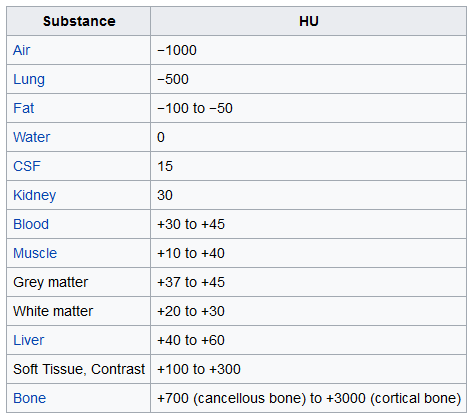

In [8]:
#hide_input
from IPython.display import Image
Image(filename='../assets/blogs/2022_01_24/hu_scale.png')

The pixel information in the DICOM file does not store the exact HU number. However, it stores the slope and intercept value needed to scale these pixels to their respective HU number. This linear relationship is described below:

$\textrm{HU} = \textrm{pixel_value} \times \textrm{slope} + \textrm{intercept}$

<br>
After processing our pixel array and converting it to Hounsfield scale, we can check the distribution of value. This bimodal distribution stems from the drastic differences in tissue properties in the acquire image. The air in the lungs and outside the body range from -1000 to -500 HU while more denser materials such as fat and cortical bone provide higher HU values of -100 to +3000 HU respectively. We'll need to remember this subtlety when normalizing our images later.

**Resampling**

We're nearly ready to save our scans to NiFTI or Nrrd format, but first let's resample the scans to the appropriate pixel spacing and slice thickness. We'll need to resample each scan to the same pixel spacing since regions of interest such as lesions or organs may be of completely different scale from patient to patient. 

In [9]:
class ProcessData:
    '''Class to process and resample DICOM data

    Args:
        dcm (DicomInterface): Dicom object of data to be processed
    '''
    def __init__(self, dcm: DicomInterface):
        self.dcm = dcm
        
    def load_volume(self, new_spacing: np.ndarray = np.array([])) -> np.ndarray:
        '''Load volume from dicom pixel array, convert to HU, and optionally resample
        
        Args:
            new_spacing (np.ndarray): New pixel spacing of dicom volume
            
        Returns:
            np.ndarray of HU pixel volume and optionally resampled
        '''
        volume = np.stack([s.pixel_array for s in self.dcm.dicoms])
        processed_volume = self._convert_to_hu(volume)
        
        if new_spacing.any():
            processed_volume = self._resample_volume(processed_volume, new_spacing)
        return processed_volume    
    
    def _resample_volume(self, volume: np.ndarray, new_spacing: np.ndarray) -> np.ndarray:
        '''Resample volume to new pixel spacing.
        
        Args:
            volume (np.ndarray): Volume of pixel array with original pixel spacing
            new_spacing (np.ndarray): New pixel spacing of volumed pixel array
            
        Returns:
            np.ndarray of resampled volume
        '''
        resize_factor = self.pixel_spacing / new_spacing
        resampled_volume = scipy.ndimage.interpolation.zoom(volume, resize_factor, mode='nearest')

        return resampled_volume

    def _convert_to_hu(self, volume: np.ndarray) -> np.ndarray:
        '''Scale original dicom pixel array volume to HU.
        
        Args:
            volume (np.ndarray): Volume of unscaled pixel array
        
        Returns:
            np.ndarray rescaled to HU
        '''
        slope = self.dcm.dicoms[0].RescaleSlope
        intercept = self.dcm.dicoms[0].RescaleIntercept
        
        processed_volume = volume * slope + intercept
        
        processed_volume[processed_volume < -1024] = -1024
        return processed_volume
    
    @property
    def modality(self):
        '''Modality of DICOM files
        Tag - Name: (0008, 0060) - Modality
        '''
        _modality = self.dcm.dicoms[0].Modality
        return _modality
    
    
    @property
    def pixel_spacing(self):
        '''Pixel spacing of loaded volume in (z,y,x) format
        Tag - Name: (0018, 0050) - Slice Thickness
        Tag - Name: (0028, 0030) - Pixel Spacing
        '''
        slice_thickness = float(self.dcm.dicoms[0].SliceThickness)
        yx_spacing = tuple(np.array(self.dcm.dicoms[0].PixelSpacing, dtype=float))
        _pixel_spacing = (slice_thickness,) + yx_spacing
        return np.array(_pixel_spacing)

In [10]:
dcm = filtered_dcms[3]
dcm.modality

'CT'

In [11]:
%%time
data = ProcessData(dcm)
volume = data.load_volume(new_spacing=np.array([1,1,1]))
# volume = data.load_volume()

CPU times: user 40 s, sys: 2.83 s, total: 42.8 s
Wall time: 43.3 s


volume.min()=-1296.2280904406302, volume.max()=3696.962930487868


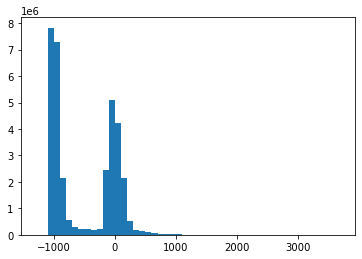

In [17]:
plt.hist(volume.ravel(), bins=50)
print(f"{volume.min()=}, {volume.max()=}")
plt.show()

Since we're working with grayscale images, the intensity of the black varies according to the minimum and maximum values. The black pixels in the HU images are equivalent (-1024 HU) to the pixels in the lung and outside the body for the raw DICOM pixel array. Since we masked all pixels < -1024, we no longer obtain a cylinder surrounding the body and set them all equivalent to air. If you're curious why we're obtaining a circle around each slice, it's because of the CT scan itself and how it emits and receives X-Rays all around the patient's body. However, since we resample our volume, there's slight error in the HU pixel valu 

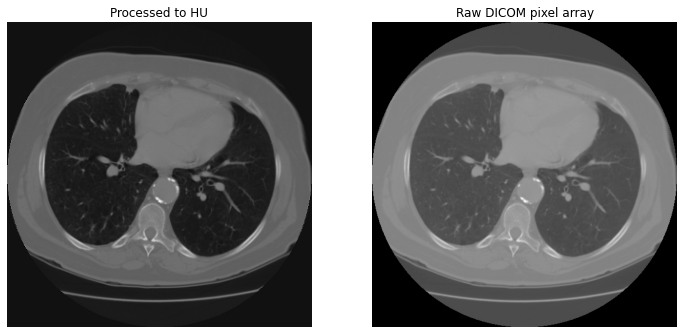

In [18]:
f, axs = plt.subplots(1,2, figsize=(12,12))
m1 = volume.shape[0]//2
m2 = len(dcm.dicoms)//2

axs[0].imshow(volume[m1,...], cmap=plt.cm.gray)
axs[0].set_title('Processed to HU')
axs[1].imshow(dcm.dicoms[m2].pixel_array, cmap=plt.cm.gray)
axs[1].set_title('Raw DICOM pixel array')

for a in axs:
    a.axis('off')
    
f.show()

## Image Windowing

Image windowing is extensively used by radiologists to view anatomical structures. It enhances the contrast for grayscale images by manipulating CT numbers to particular ranges. The brightness of the image is able to be adjusted via the window level/center and the contrast of the image via the window width. Typically, medical images viewers such as [Slicer](https://www.slicer.org/) allow the user to adjust these values relatively easily. However, we will show a simple example here how windowing works. It's important to note that window centers and widths can also vary depending on the manufacturer. Generally, the following window levels and widths listed in HU are used to view particular [anatomical regions](https://radiopaedia.org/articles/windowing-ct):

- head and neck
    - brain W:80 L:40
    - subdural W:130-300 L:50-100
    - stroke W:8 L:32 or W:40 L:40
    - temporal bones W:2800 L:600 or W:4000 L:700
    - soft tissues: W:350–400 L:20–60
- chest
    - lungs W:1500 L:-600
    - mediastinum W:350 L:50
- abdomen
    - soft tissues W:400 L:50
    - liver W:150 L:30
- spine
    - soft tissues W:250 L:50
    - bone W:1800 L:400

We can either grab the window center and width from our DICOM metadata or check from the values above. To access it from the DICOM metadata, we would simply access the ```WindowCenter``` or ```WindowCenter``` property from our ```pydicom.dataset.FileDataset``` object.

In [19]:
# tuple of window level and window width
window_dict = {'head and neck': {'brain': (40, 80),
                                 'subdural': (75, 215),
                                 'stroke': (32,8),
                                 'temporal bones': (600, 2800),
                                 'soft tissues': (40, 375)},
               'chest': {'lungs': (-600,1500),
                         'mediastinum': (50, 350)},
               'abdomen': {'soft tissue': (50, 400),
                           'liver': (30, 150)},
               'spine': {'soft tissue': (50, 250),
                         'bone': (400, 1800)}
              }

In [20]:
def window_image(volume: np.ndarray, window_center: int, window_width: int):
    '''Windows the CT scan to a desired range of values
    '''
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_volume = volume.copy()
    window_volume[window_volume < img_min] = img_min
    window_volume[window_volume > img_max] = img_max
    
    return window_volume

In [21]:
data.dcm.dicoms[0].WindowCenter, data.dcm.dicoms[0].WindowWidth 

('-600.0', '1600.0')

center=-600
width=1500


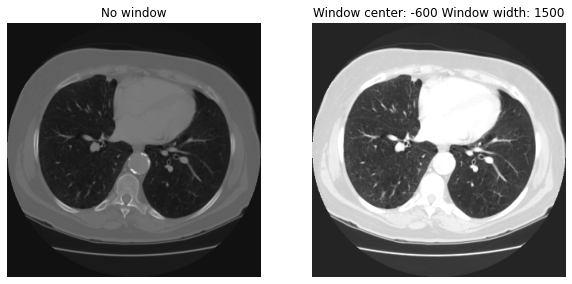

In [23]:
region = 'chest'
sub_region = 'lungs'
center, width = window_dict[region][sub_region]
print(f"{center=}")
print(f"{width=}")
image = window_image(volume, center, width)

m = volume.shape[0]//2

f, axs = plt.subplots(1,2,figsize=(10,10))
axs[0].imshow(volume[m,...],cmap=plt.cm.gray)
axs[0].set_title('No window')
axs[1].imshow(image[m,...],cmap=plt.cm.gray)
axs[1].set_title(f'Window center: {center} Window width: {width}')
for a in axs: a.axis('off')
f.show()